In [6]:

# compresses by ignoring values of same mean and variance
# consider the "harmonic mean" in adwin
# anomalies are defined as:
# same 

import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from queue import Queue
import math as math

from numpy import genfromtxt

import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [7]:


# Global Variables

EPSILON = 1.0   # threshold
WIN_MAX = 8      # max window size of post_win
MIN_PERM = 25 # minimum permance of a concept
VAR_MULT = 4  # variance multiplier to check what is outside of the variance from the mean
              # this needs to be

# current concept statistics
curr_concept_mean = 0 
curr_concept_var = 0
curr_concept_max = 0
curr_concept_min = 0

# prev concept statistics
prev_concept_mean = 0
prev_concept_var = 0
prev_concept_max = 0
prev_concept_min = 0

curr_concept_win = []
new_concept_win = []
slope = 0

drift_len = 0
SNAPSIZE = 100  # Size of snapshot to refer to model
# win = np.empty(100)           # a window behind/after adwin ("post adwin")
win = []
win_mean = []          # store post_win mean
win_var = []           # store post_win variance
data_stream = []        # Array for the data stream values
drift_snap = []       # snapshot of a drift
pre_drift_snap = []   # padding left
post_drift_snap = []  # padding right
padded_drift_snap = []  # centered drift

rms = 0  # root mean square
i = 0
in_abrupt_drift = False    # currently in a drift
in_incr_drift = False       # currently in an incremental drift

start_drift_point = 0
end_drift_point = 0
drift_length = 0
post_snap = 0
pre_snap = 0
total_snap = 0
end_abrupt_drift_point = 0
end_incr_drift_point = 0

stable = False

# create a datastructure called ConceptDrift [mean, variance, timestep]
WIN_START = WIN_MAX + MIN_PERM
dist = 0

trend = False
count_slope = 0

idx = 0

start_abrupt_drift_point = 0
end_abrupt_drift_point = 0
start_incr_drift_point = 0
end_incr_drift_point = 0

end_abrupt_drift = False
end_incr_drift = False


In [8]:
# open file
# my_data = genfromtxt('data/incremental_d_250.csv', delimiter=',')
# my_data = genfromtxt('data/abrupt_incr_500.csv', delimiter=',')
# my_data = genfromtxt('data/moa_abrupt_d_250.csv', delimiter=',')
# my_data = genfromtxt('data/test_regular_250.csv', delimiter=',')
# my_data = genfromtxt('data/test_abrupt_d_250.csv', delimiter=',')
# my_data = genfromtxt('data/test_anomalies_250.csv', delimiter=',')
# my_data = genfromtxt('data/test_gradual_dudu_250.csv', delimiter=',') # not performing as expected, maybe due to short intervals between drifts
# my_data = genfromtxt('data/test_gradual_dudu_250.csv', delimiter=',') # not performing as expected, maybe due to short intervals between drifts
# my_data = genfromtxt('data/test_incremental_d_250.csv', delimiter=',')
my_data = genfromtxt('data/test_incremental_u_anomaly_250.csv', delimiter=',')

data_stream_len = len(my_data)
print(data_stream_len)
print(my_data.shape)

250
(250,)


In [9]:
# Root-Mean-Square Deviation
def rmse(num1, num2):
  deviation = math.sqrt(((num2 - num1) * (num2  -num1)) / 2)
  
  return deviation

>>>>>> current concept | mean:33.93, min:31.45, max:36.41
>>>>>> Incremental drift detected at timestep: 69
>>>>>> Abrupt drift detected at timestep: 145
>>>>>> New concept (end abrupt) detected at timestep: 147
>>>>>> new current concept from abrupt | mean:65.65, var:2.42, min:55.96, max:75.34


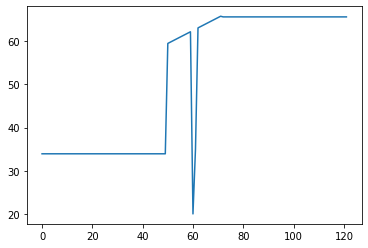

>>>>>> New concept (end incremental) detected at timestep: 202
>>>>>> new current concept from abrupt | mean:78.01, var:0.29, min:76.84, max:79.17
>>>>>> new current concept from incremental | mean:78.03, var:0.3, min:76.82, max:79.23


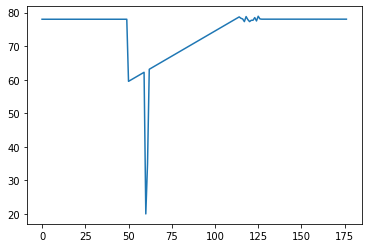

In [10]:



for i in range(data_stream_len):

  
  #   win_mean.insert(i,np.mean(win))
  #   win_var.insert(i,np.var(win))

  # get current concept mean and variance over MIN PERM (Minimum Permanance)
  if (i <= MIN_PERM):
    curr_concept_win.insert(i,my_data[i])
    # print(f"Initial:{i}, {round(curr_concept_win[i],2)}, Mean: {round(np.nanmean(curr_concept_win),2)}")
    if i == MIN_PERM: # when current concept window size is reached, calculate stats
      curr_concept_mean = np.nanmean(curr_concept_win)
      curr_concept_var = np.nanvar(curr_concept_win)
      curr_concept_max = curr_concept_mean + (VAR_MULT * curr_concept_var)
      curr_concept_min = curr_concept_mean - (VAR_MULT * curr_concept_var)
      print(f">>>>>> current concept | mean:{round(curr_concept_mean,2)}, min:{round(curr_concept_min,2)}, max:{round(curr_concept_max,2)}")

  # search for drift outside of current concept 
  else:

    # get min WIN_MAX data points points
    if i <= (WIN_START): 
      win.insert(i,my_data[i])
      win_mean.insert(i,np.mean(win))
      win_var.insert(i,np.var(win))

  # if there are enough data points (WIN_MAX)
    else: 
      win.pop(0)    # pop the oldest data point
      win_mean.pop(0)
      win_var.pop(0)

      win.insert(i,my_data[i])  # insert the newest data point
      win_mean.insert(i,np.mean(win)) # calculate and 
      win_var.insert(i,np.var(win))

      # current values
      curr_value = round(win[WIN_MAX-1],2)
      curr_win_mean = round(win_mean[WIN_MAX-1],2)
      curr_win_var = round(win_var[WIN_MAX-1],2)
      

      # Other Statistics (RMSE & SLOPE)
      if i < data_stream_len:
        rms = rmse(win[WIN_MAX-1], win[WIN_MAX-4])  # adjust steps for rms
        curr_rms = round(rms,2)
        # calculate the slope from beginning of drift to end of drift vs curr_concept_mean
        # replace 3 with in an distance incrementer and reset when drift is over
        
        slope = (win[WIN_MAX-1] - win[WIN_MAX-4]) / 3 # 3 is the number of time steps (x2-x1)
        # print(f"Slope:{round(slope,2)}")
        
        # Slope trend: trending down or up (curr_mean < concept_min and slope is neg consecutively) OR (curr_mean > concept_max and slow is pos consecutively)
        
        # if slope is negative for the first time
        
        if slope >= 0 and trend == False:
          trend = True
          count_slope = 0

        elif slope < 0 and trend == True:
          trend = False
          count_slope = 0

        elif slope < 0 and trend == False:
          count_slope -= 1

        elif slope >= 0 and trend == True:
          count_slope += 1       

        else: print(" *** SLOPE AND/OR TREND CALCULATION ERROR ***")

      
      # print(f"{i}. Value:{curr_value}, Mean:{round(curr_win_mean,2)}, Var:{round(curr_win_var,2)}, RMS:{round(curr_rms,2)}, curr_mean:{round(curr_concept_mean,2)}, curr_var:{round(curr_concept_var,2)}, curr_min:{round(curr_concept_min,2)}, curr_max:{round(curr_concept_max,2)}, slope:{round(slope,2)}")

      # ABRUPT DRIFT DETECTION
      # START: if drift is detected (ie. var > 2 AND RMS > 2), the value 2 is random observation, check if length is long enough to be considered minimum permanance
      if (((curr_value < curr_concept_min) or (curr_value > curr_concept_max)) \
          and (curr_rms > (EPSILON*2)) \
          and (in_abrupt_drift == False) \
          and ((i - start_drift_point) > (MIN_PERM - WIN_MAX)) \
          ):

        in_abrupt_drift = True
        end_abrupt_drift = False
        stable = False
        start_drift_point = i
        print(f">>>>>> Abrupt drift detected at timestep: {start_drift_point}") 
        # print(f">>>>>> current concept | mean:{round(curr_concept_mean,2)}, min:{round(curr_concept_min,2)}, max:{round(curr_concept_max,2)}")
        

      # END: if coming out of a drift, *** to add check with mean and variance
      if (curr_rms < EPSILON) and (in_abrupt_drift == True):
        in_abrupt_drift = False
        end_abrupt_drift = True
        end_drift_point = i
        new_concept_win.clear()   
        print(f">>>>>> New concept (end abrupt) detected at timestep: {end_drift_point}") 
        # print(f">>>>>> current concept | mean:{round(curr_concept_mean,2)}, min:{round(curr_concept_min,2)}, max:{round(curr_concept_max,2)}")
        # print(f"length of new_concept_win:{len(new_concept_win)}")

      # *** get current concept mean and variance over MIN PERM (Minimum Permanance) ***


      # INCREMENTAL DRIFT DETECTION
      # START: if mean < curr_mean + curr_var < mean and not in abrupt drift
      if (((curr_win_mean < curr_concept_min) or (curr_win_mean > curr_concept_max)) \
          and (count_slope > (WIN_MAX*2) or count_slope < (-WIN_MAX*2)) \
          and (in_incr_drift == False) \
          and (in_abrupt_drift == False) \
          and ((i - start_drift_point) > (MIN_PERM - WIN_MAX)) \
          ):    # should not in in the midst of an abrupt drift

        in_incr_drift = True
        end_incr_drift = False
        stable = False
        start_drift_point = i
        print(f">>>>>> Incremental drift detected at timestep: {start_drift_point}") 
        # print(f">>>>>> current concept | mean:{round(curr_concept_mean,2)}, var:{round(curr_concept_var,2)}, min:{round(curr_concept_min,2)}, max:{round(curr_concept_max,2)}")

      # END: when no longer sloping calculate new concept mean and var
      if ((count_slope == EPSILON or count_slope == -EPSILON) and (in_incr_drift == True) and ((i - start_drift_point) > (MIN_PERM - WIN_MAX))):
        in_incr_drift = False
        end_incr_drift = True
        end_drift_point = i
        dist = 0
        new_concept_win.clear()
        
        print(f">>>>>> New concept (end incremental) detected at timestep: {end_drift_point}") 
        # print(f">>>>>> current concept | mean:{round(curr_concept_mean,2)}, var:{round(curr_concept_var,2)}, min:{round(curr_concept_min,2)}, max:{round(curr_concept_max,2)}")
        # print(f"length of new_concept_win:{len(new_concept_win)}")
        
        


      

    # *** get current concept mean and variance over MIN PERM (Minimum Permanance) ***
    if ((in_abrupt_drift == False) and (end_abrupt_drift == True)):
      new_concept_win.insert(i,my_data[i])
      
      if i == (end_drift_point + MIN_PERM - WIN_MAX): # when current concept window size is reached, calculate stats
        stable = True
        
        # save previous stats for padding
        prev_concept_mean = curr_concept_mean
        prev_concept_var = curr_concept_var
        prev_concept_min = curr_concept_min
        prev_concept_max = curr_concept_max

        # update current stats
        curr_concept_mean = np.nanmean(new_concept_win)
        curr_concept_var = np.nanvar(new_concept_win)
        curr_concept_max = curr_concept_mean + (VAR_MULT * curr_concept_var)
        curr_concept_min = curr_concept_mean - (VAR_MULT * curr_concept_var)
        # print(f"length of new_concept_win:{len(new_concept_win)}")
        print(f">>>>>> new current concept from abrupt | mean:{round(curr_concept_mean,2)}, var:{round(curr_concept_var,2)}, min:{round(curr_concept_min,2)}, max:{round(curr_concept_max,2)}")
        
        

    # *** get current concept mean and variance over MIN PERM (Minimum Permanance) ***
    if ((in_incr_drift == False) and (end_incr_drift == True)):
      new_concept_win.insert(i,my_data[i])

      if i == (end_drift_point + MIN_PERM - WIN_MAX): # when current concept window size is reached, calculate stats
        stable = True

        # save previous stats for padding
        prev_concept_mean = curr_concept_mean
        prev_concept_var = curr_concept_var
        prev_concept_min = curr_concept_min
        prev_concept_max = curr_concept_max

        curr_concept_mean = np.nanmean(new_concept_win)
        curr_concept_var = np.nanvar(new_concept_win)
        curr_concept_max = curr_concept_mean + (VAR_MULT * curr_concept_var)
        curr_concept_min = curr_concept_mean - (VAR_MULT * curr_concept_var)
        # print(f"length of new_concept_win:{len(new_concept_win)}")
        print(f">>>>>> new current concept from incremental | mean:{round(curr_concept_mean,2)}, var:{round(curr_concept_var,2)}, min:{round(curr_concept_min,2)}, max:{round(curr_concept_max,2)}")
        
      
    # check if new_concept_mean < (curr_concept_mean +/- curr_concept_var)
    # then concat?

    if (stable == True):
      # print(f"stable:{stable}")
      k = 0
      # new_concept_win.clear()
      # print(f"new_concept_win cleared! len:{len(new_concept_win)}")

      # start = start_drift_point - MIN_PERM
      # end = end_drift_point + MIN_PERM
      # start = start_drift_point - WIN_MAX
      # end = end_drift_point + WIN_MAX
      start = start_drift_point - 10
      end = end_drift_point + 10
      
      # larger than snapshot size then compress
      if ((end - start) > SNAPSIZE):  
        mod = math.ceil((end-start)/ SNAPSIZE)
        # print(f"mod:{mod}")
        for j in range(start, end):
          if k % mod == 0:
            drift_snap.insert(k,my_data[j])
            # print(f"inserting k:{k}, value:{my_data[j]}")
          k += 1
                                
        # pad remainder to the right only
        for l in range(0,SNAPSIZE-len(drift_snap)):
          drift_snap.insert(k,curr_concept_mean)
        
        # print(f"total drift snap (larger win):{len(drift_snap)}")
        # stable = False
        # print(f"drift_snap length:{len(drift_snap)}")
        plt.plot(drift_snap)
        plt.show()
        # drift_snap.clear() # clears array
      
      # smaller than snapshot size then pad
      else:
        for j in range(start, end):
          drift_snap.insert(k,my_data[j])
          # print(f"inserting k:{k}, value:{my_data[j]}")
          k += 1
        
        # check even
        if drift_len % 2 == 0:
          pre_snap = post_snap = int(SNAPSIZE - drift_len) / 2

        else:
          pre_snap = math.ceil((SNAPSIZE - drift_len) / 2)
          post_snap = math.floor((SNAPSIZE - drift_len) / 2)

        # pad drift snapshot
        for pre in range(0,int(pre_snap)):
          pre_drift_snap.insert(pre,prev_concept_mean)

        for post in range(0,int(post_snap)):
          post_drift_snap.insert(post,curr_concept_mean)

        padded_drift_snap = np.concatenate((pre_drift_snap, drift_snap, post_drift_snap), axis=None)
            
        # total_snap = pre_snap + drift_len + post_snap
        # print(f"drift length:{drift_len}, pre snap:{pre_snap}, post snap:{post_snap}, total snap:{len(padded_drift_snap)}")
        
        # print(f"drift_snap length:{len(drift_snap)}")
        plt.plot(padded_drift_snap)
        plt.show()
        
      # clears array
      drift_snap.clear()
      pre_drift_snap.clear()
      post_drift_snap.clear()
                       
      k = 0 # reset k
      stable = False
     
# store average mean and var => concept 1
# when the RMS > 1 and Var > 1 trigger (save drift step) until RMS < 1 => new concept (save drift step)
# compare concept 1 vs concept 2 vs concept 3, etc. to see if there's recurrence. 


## make new concept = 50 steps (mean of 50 steps, variance of 50 steps)
  
  



# replace with while loop to keep feeding the data stream


